## **CRO'S PRICE PREDICTION THROUGH ARIMA**

In [1]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 7.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 53.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
## Library
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import auto_arima
from scipy import stats
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import InterpolationWarning

import warnings
warnings.filterwarnings("ignore")

In [5]:
## Load Data
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df_CRO_RAW = yf.download('CRO-USD', 
                       start='2019-6-30', 
                       end='2022-1-16', 
                       parse_dates=['date'], 
                       index_col='date', 
                       date_parser=dateparse,
                       progress=False)
print(f'Downloaded {df_CRO_RAW.shape[0]} rows of data.')
df_CRO_RAW.to_excel("CRO_RAW.xlsx")
df_cro = pd.read_excel("CRO_RAW.xlsx")
# df_cro.head(20)


Downloaded 932 rows of data.


In [6]:
## Read Data
df_cro["Symbol"] = "CRO"
df_cro

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,2019-06-30,0.063360,0.069947,0.057197,0.061162,0.061162,6550538,CRO
1,2019-07-01,0.061162,0.065025,0.051503,0.056784,0.056784,5771235,CRO
2,2019-07-02,0.056157,0.059115,0.048205,0.055500,0.055500,4888326,CRO
3,2019-07-03,0.055727,0.068474,0.055727,0.067856,0.067856,6178373,CRO
4,2019-07-04,0.067710,0.074430,0.062899,0.071698,0.071698,3615473,CRO
...,...,...,...,...,...,...,...,...
927,2022-01-12,0.458830,0.493290,0.458618,0.486546,0.486546,178944129,CRO
928,2022-01-13,0.486519,0.491958,0.456009,0.456061,0.456061,150766601,CRO
929,2022-01-14,0.456170,0.467545,0.447214,0.456634,0.456634,132753870,CRO
930,2022-01-15,0.456681,0.473361,0.456315,0.467501,0.467501,120922480,CRO


In [7]:
## Check Data
# df_cro.isnull().sum()
# df_cro.dropna()

**Candlestick**

In [8]:
fig = go.Figure(data=[go.Candlestick(x=df_cro['Date'],
                open=df_cro['Open'],
                high=df_cro['High'],
                low=df_cro['Low'],
                close=df_cro['Close'], 
                increasing_line_color= 'cyan', decreasing_line_color= 'gray')])
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

**Aggregate to optionally frequency**

In [9]:
df_cro.set_index("Date",inplace = True)
cronos = pd.DataFrame(df_cro.loc[:, ['Close', 'Volume']], index=df_cro.index)
# Aggregate to monthly frequency
cronos_m = cronos.resample('M').mean().copy()
# Aggregate to weekly frequency
cronos_w = cronos.resample('W').mean().copy()
# Time_list
cronos_lst = [cronos_w,cronos_m]
for i in cronos_lst:
  print(i) 

               Close        Volume
Date                              
2019-06-30  0.061162  6.550538e+06
2019-07-07  0.066920  4.294861e+06
2019-07-14  0.085871  1.719285e+07
2019-07-21  0.057557  4.897468e+06
2019-07-28  0.061941  8.396253e+06
...              ...           ...
2021-12-19  0.531151  2.117676e+08
2021-12-26  0.580224  3.497191e+08
2022-01-02  0.574550  2.284561e+08
2022-01-09  0.500874  2.060952e+08
2022-01-16  0.462040  1.439510e+08

[134 rows x 2 columns]
               Close        Volume
Date                              
2019-06-30  0.061162  6.550538e+06
2019-07-31  0.067049  8.339419e+06
2019-08-31  0.046705  1.018087e+07
2019-09-30  0.038349  7.966439e+06
2019-10-31  0.034771  8.550176e+06
2019-11-30  0.033813  1.517992e+07
2019-12-31  0.031485  7.306398e+06
2020-01-31  0.043647  1.163139e+07
2020-02-29  0.058983  1.896780e+07
2020-03-31  0.044200  1.216076e+07
2020-04-30  0.051693  7.274001e+06
2020-05-31  0.069552  1.574822e+07
2020-06-30  0.112034  5.236564e

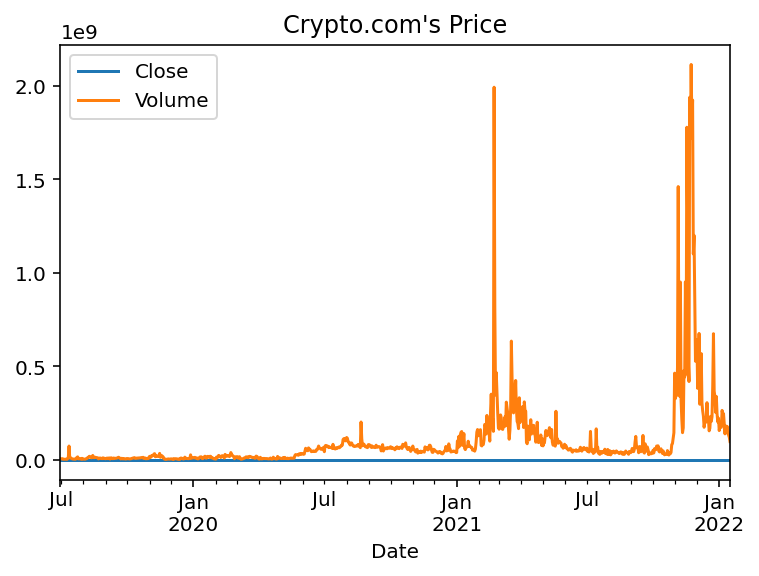

In [10]:
# Plot the prices:
cronos.plot(title="Crypto.com's Price")

# Stationarity Test

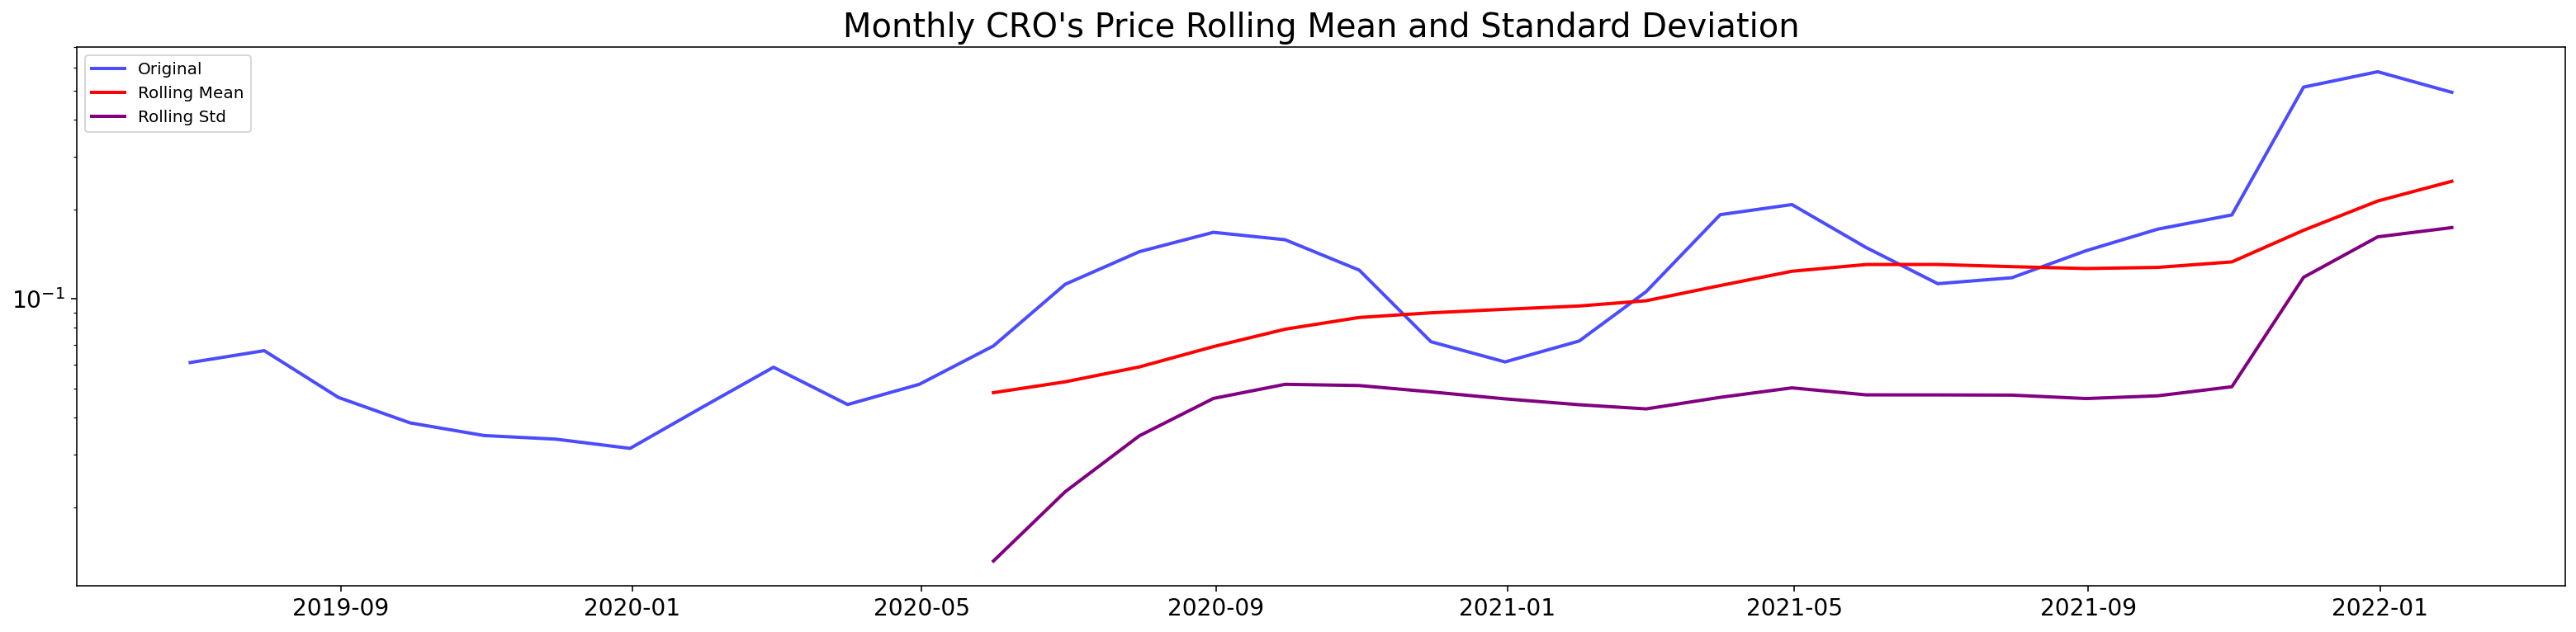

In [11]:
#Add the rolling mean and standard deviation
WINDOW_SIZE = 12 #12 tháng
cronos_m['rolling_mean'] = cronos_m['Close'].rolling(window=WINDOW_SIZE).mean()
cronos_m['rolling_std'] = cronos_m['Close'].rolling(window=WINDOW_SIZE).std()
cronos_m['rolling_mean'].dropna()
cronos_m['rolling_std'].dropna()
# Visualize
fig = plt.figure(figsize=(27, 6))
price = plt.semilogy(cronos_m['Close'], color='blue',label='Original', lw=2, alpha=0.7)
mean = plt.semilogy(cronos_m['rolling_mean'], color='red', label='Rolling Mean', lw=2)
std = plt.semilogy(cronos_m['rolling_std'], color='purple', label = 'Rolling Std', lw=2)
plt.legend(loc='best')
plt.title("Monthly CRO's Price Rolling Mean and Standard Deviation", fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14, rotation=0)
plt.show()



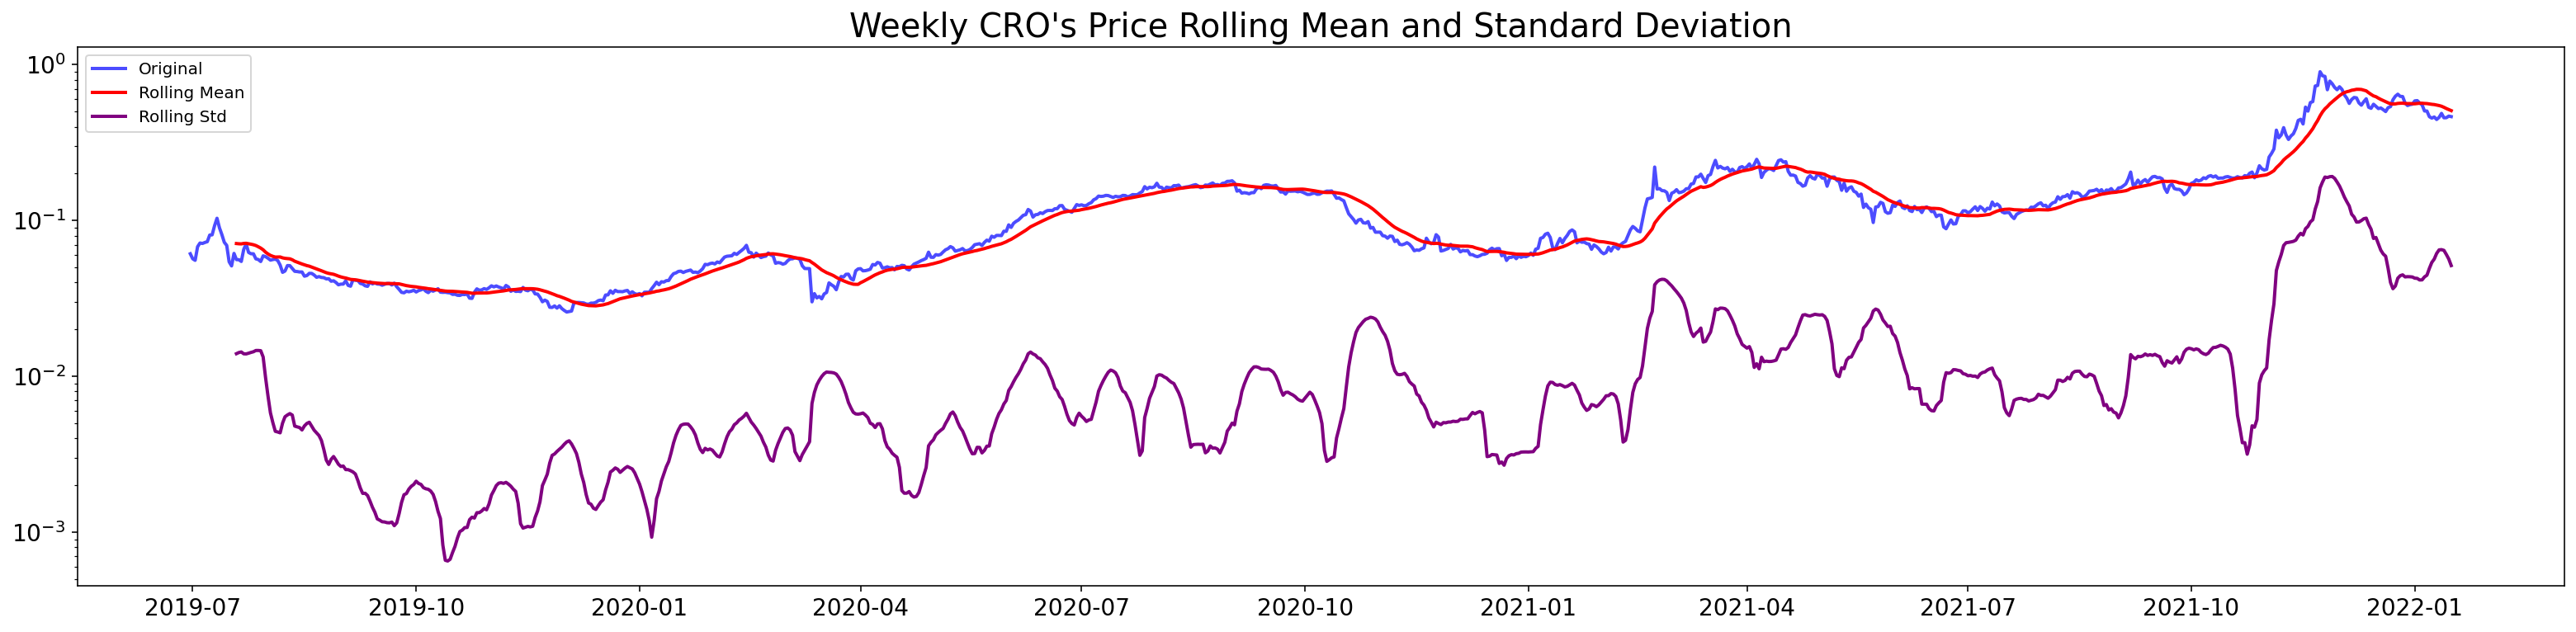

In [12]:
#Add the rolling mean and standard deviation
WINDOW_SIZE = 20 
cronos['rolling_mean'] = cronos['Close'].rolling(window=WINDOW_SIZE).mean()
cronos['rolling_std'] = cronos['Close'].rolling(window=WINDOW_SIZE).std()
cronos['rolling_mean'].dropna()
cronos['rolling_std'].dropna()
# Visualize
fig = plt.figure(figsize=(27, 6))
price = plt.semilogy(cronos['Close'], color='blue',label='Original', lw=2, alpha=0.7)
mean = plt.semilogy(cronos['rolling_mean'], color='red', label='Rolling Mean', lw=2)
std = plt.semilogy(cronos['rolling_std'], color='purple', label = 'Rolling Std', lw=2)
plt.legend(loc='best')
plt.title("Weekly CRO's Price Rolling Mean and Standard Deviation", fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14, rotation=0)
plt.show()

#:Testing for stationarity in time series _ monthly

In [14]:
# Define a function for running the ADF test:
def adf_test(x):
  indices = ['Test Statistic', 'p-value',
  '# of Lags Used', '# of Observations Used']
  adf_test = adfuller(x, autolag='AIC')
  results = pd.Series(adf_test[0:4], index=indices)
  for key, value in adf_test[4].items():
    results[f'Critical Value ({key})'] = value
  return results

In [40]:
adf_test(cronos_m['Close'])

Test Statistic             0.678318
p-value                    0.989395
# of Lags Used             9.000000
# of Observations Used    22.000000
Critical Value (1%)       -3.769733
Critical Value (5%)       -3.005426
Critical Value (10%)      -2.642501
dtype: float64

In [16]:
# Define a function for running the KPSS test:
def kpss_test(x, h0_type='c'):
  indices = ['Test Statistic', 'p-value', '# of Lags']
  kpss_test = kpss(x, regression=h0_type)
  results = pd.Series(kpss_test[0:3], index=indices)
  for key, value in kpss_test[3].items():
    results[f'Critical Value ({key})'] = value
  return results

In [17]:
kpss_test(cronos_m['Close'])

Test Statistic           0.609438
p-value                  0.021778
# of Lags                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

In [41]:
adfuller(cronos_m['Close']) 
#p-value : 0.9893950924998931 
# Probability that null hypothesis will not be rejected(p-value)=>  Non Stationarity exists in the series.

(0.6783183292092191,
 0.9893950924998931,
 9,
 22,
 {'1%': -3.769732625845229,
  '10%': -2.6425009917355373,
  '5%': -3.005425537190083},
 -50.251624383418644)

In [42]:
kpss(cronos_m['Close'])

(0.6094380770861836,
 0.021778356628528762,
 3,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

#Seasonal decomposition

Text(0.5, 0.98, 'Multiplicative Decomposition')

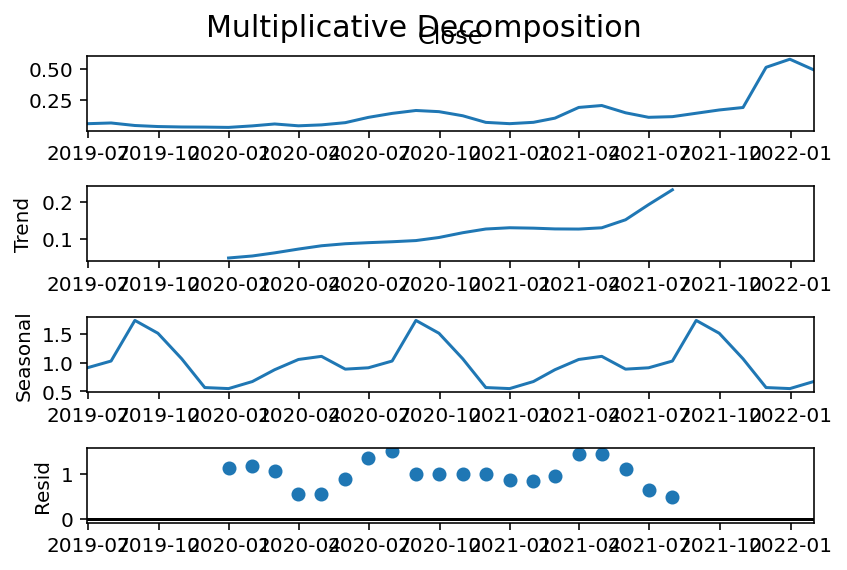

In [18]:
# Carry out seasonal decomposition using the multiplicative model
decomposition_results = seasonal_decompose(cronos_m['Close'],model='multiplicative')
decomposition_results.plot() \
.suptitle('Multiplicative Decomposition',fontsize=15)

Text(0.5, 0.98, 'Multiplicative Decomposition')

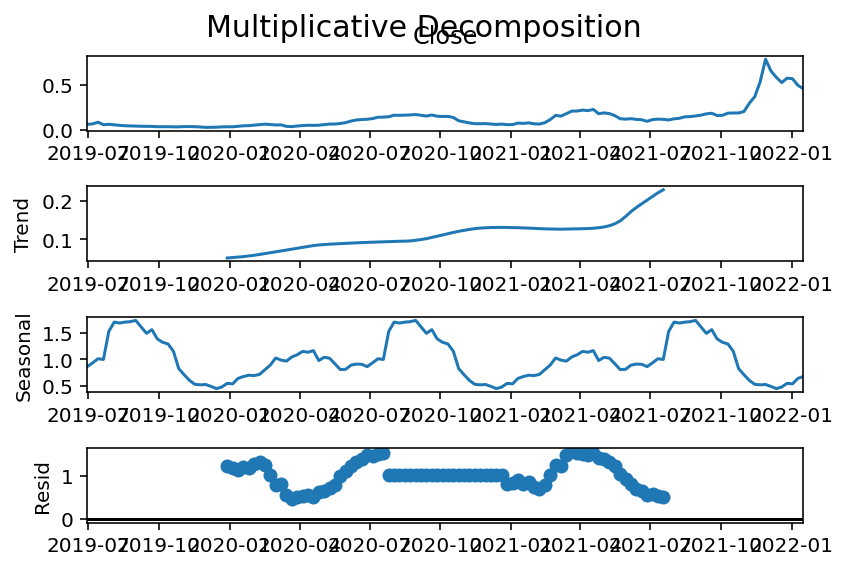

In [19]:
# Carry out seasonal decomposition using the multiplicative model
decomposition_results = seasonal_decompose(cronos_w['Close'],model='multiplicative')
decomposition_results.plot() \
.suptitle('Multiplicative Decomposition',fontsize=15)

# Autocorrelations (ADF) and Partial autocorrelations (PADF)

<Figure size 576x432 with 0 Axes>

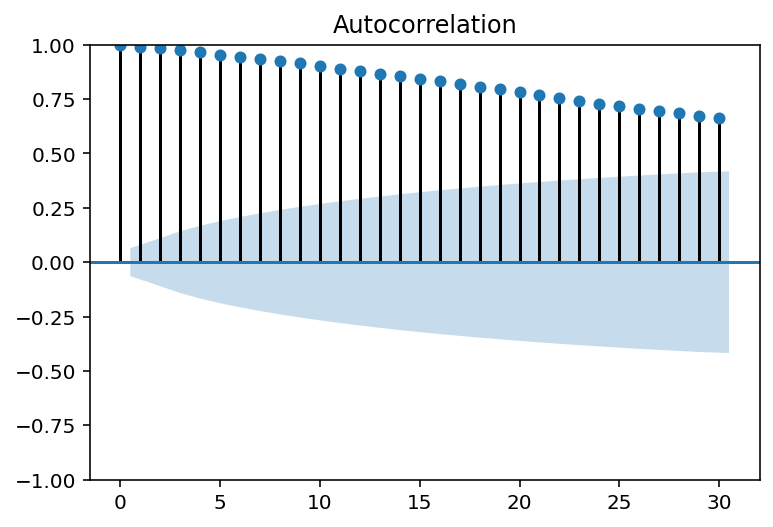

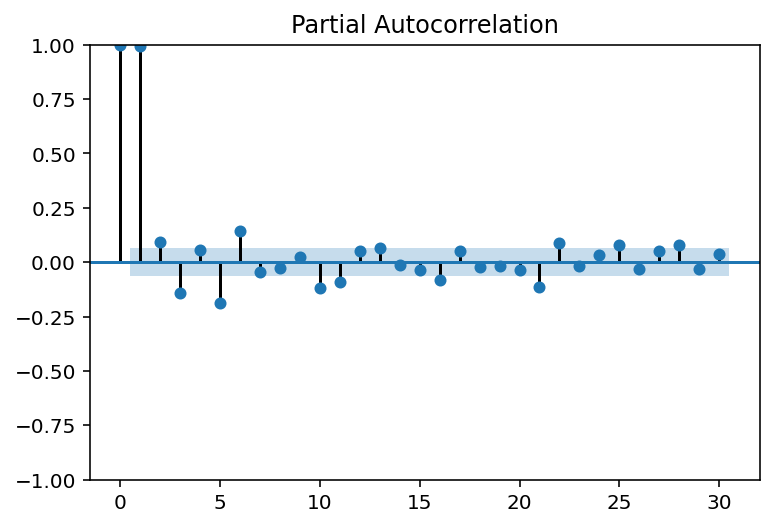

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax1 = plot_acf(cronos['Close'])
ax2 = plot_pacf(cronos['Close'])

<Figure size 576x432 with 0 Axes>

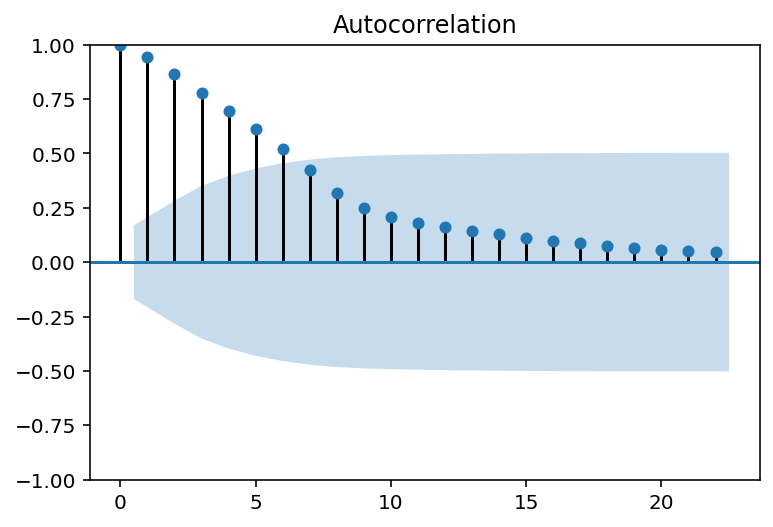

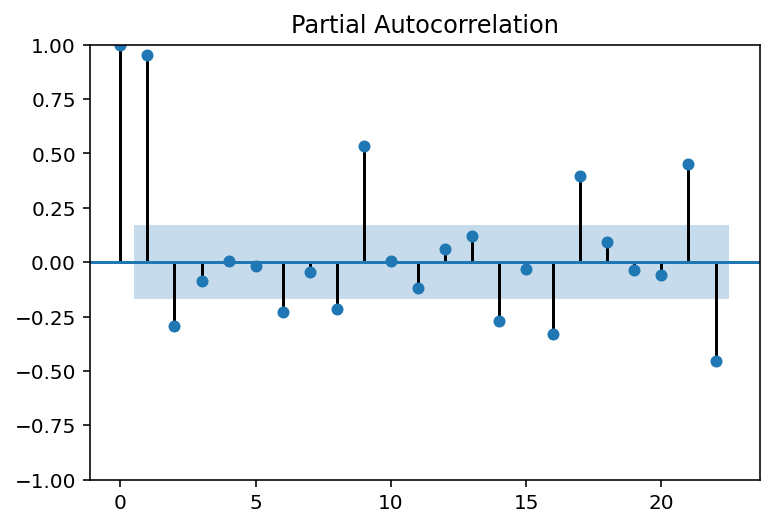

In [21]:
plt.figure(figsize = (8, 6))
ax1_w = plot_acf(cronos_w['Close'])
ax2_w = plot_pacf(cronos_w['Close'])

In [24]:
# plt.figure(figsize = (12, 6))
# ax1_w = plot_acf(cronos_m['Close'])
# ax2_w = plot_pacf(cronos_m['Close'])

# **ARIMA**

In [26]:
cronos2 = df_cro.resample('W').mean() 
# \
# .last() \
# .rename(columns={'Adj Close': 'adj_close'}) \
# .adj_close

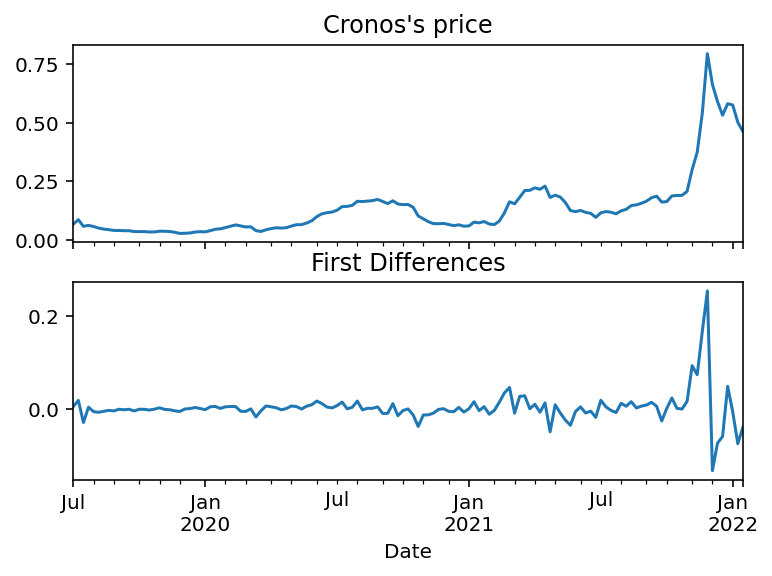

In [27]:
# Apply the first differences to the price series and plot them together:
cronos_diff = cronos2['Close'].diff().dropna()
fig, ax = plt.subplots(2, sharex=True)
cronos2['Close'].plot(title = "Cronos's price", ax=ax[0])
cronos_diff.plot(ax=ax[1], title='First Differences')

In [28]:
def test_autocorrelation(x, n_lags=40, alpha=0.05, h0_type='c'):
    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type=h0_type)

    print('ADF test statistic: {:.2f} (p-val: {:.2f})'.format(adf_results['Test Statistic'],
                                                             adf_results['p-value']))
    print('KPSS test statistic: {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Statistic'],
                                                              kpss_results['p-value']))

    fig, ax = plt.subplots(2, figsize=(16, 8))
    plot_acf(x, ax=ax[0], lags=n_lags, alpha=alpha)
    plot_pacf(x, ax=ax[1], lags=n_lags, alpha=alpha)

    return fig

ADF test statistic: -3.10 (p-val: 0.03)
KPSS test statistic: 0.12 (p-val: 0.10)


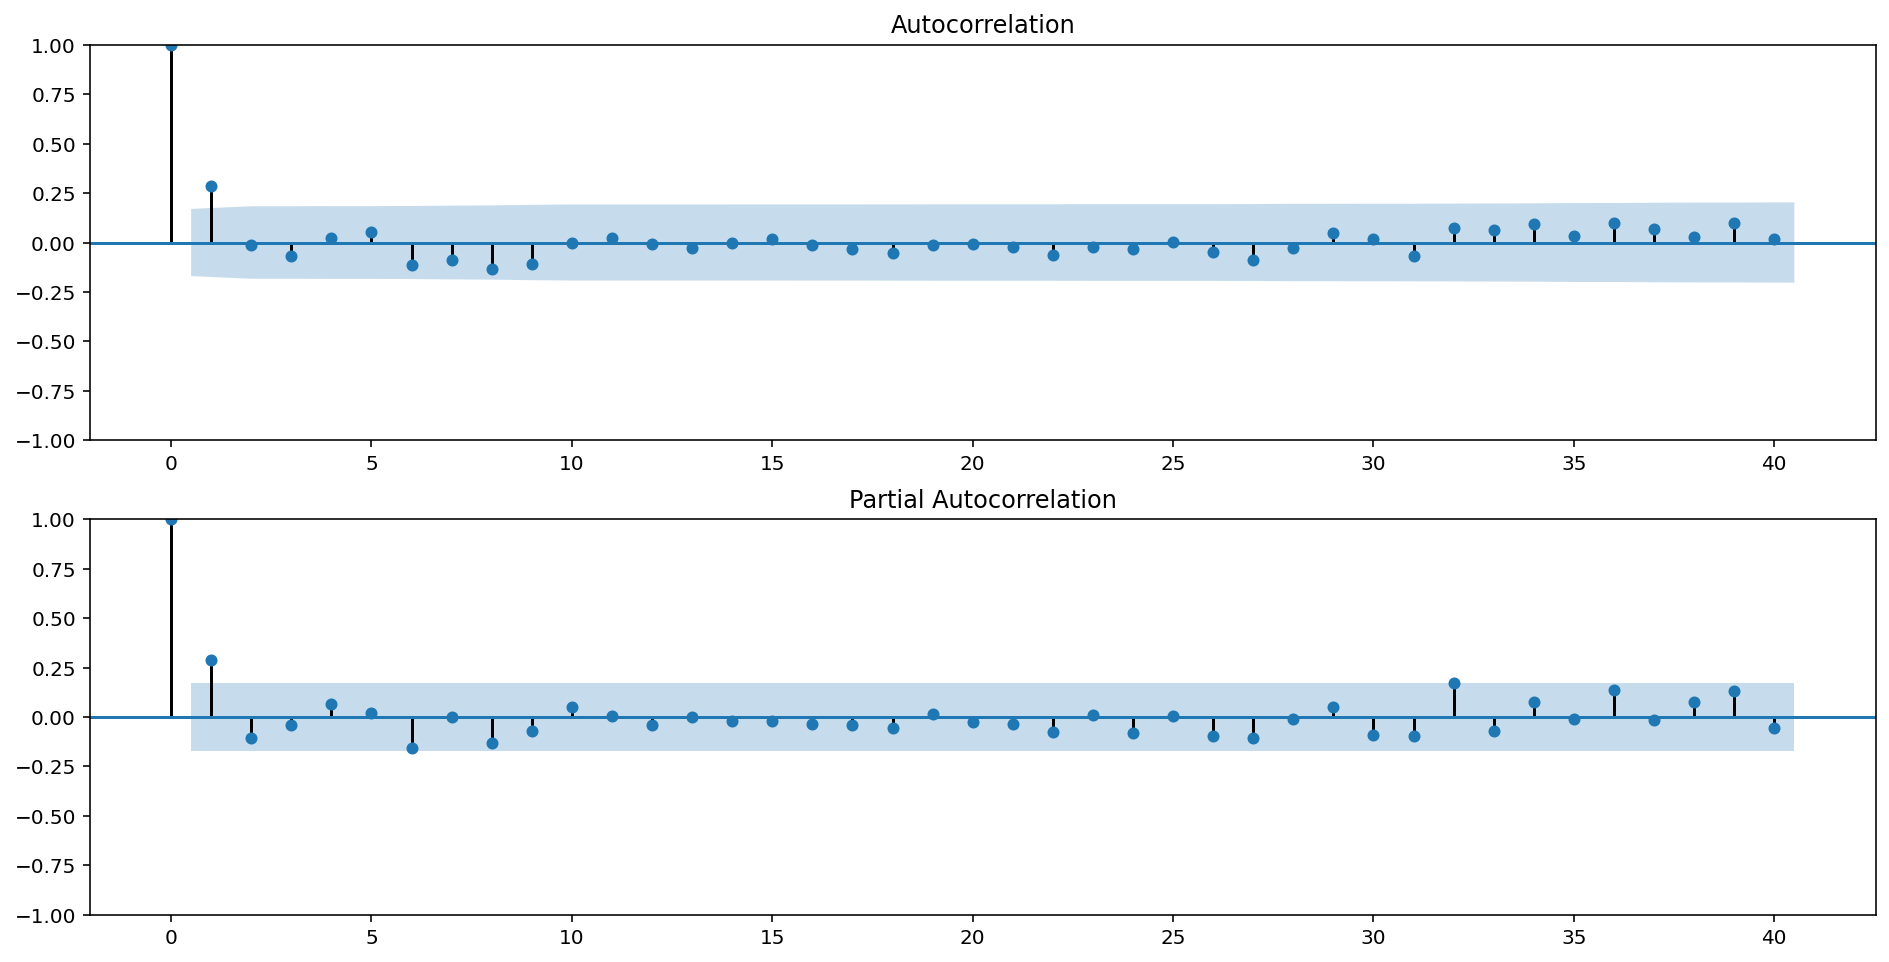

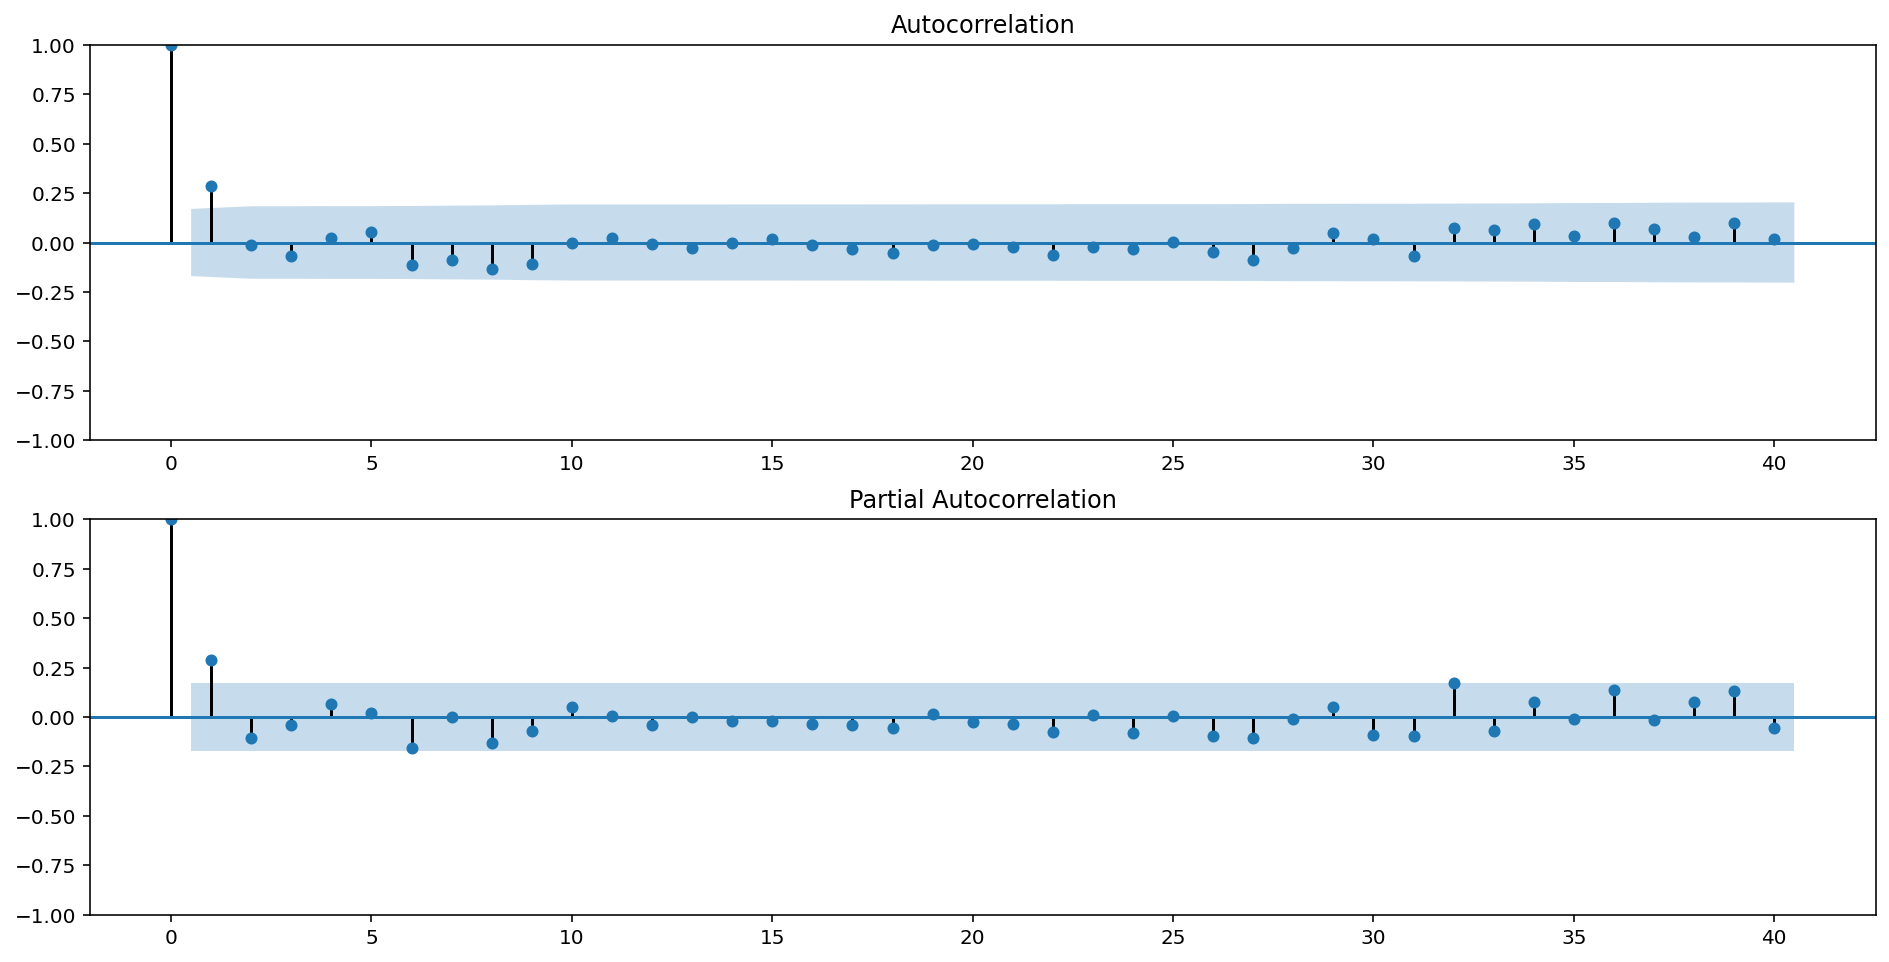

In [29]:
# Test the differenced series for stationarity:
test_autocorrelation(cronos_diff)
# ADF test statistic: -3.10 (p-val: 0.03)
# KPSS test statistic: 0.12 (p-val: 0.10)
#The results indicate that the differenced prices are stationary. => (p,d,q) = (2, 1, 2)

In [30]:
from statsmodels.tsa.arima.model import ARIMA
# Based on the results of the tests, specify the ARIMA model and fit it to the data:
arima = ARIMA(cronos_w['Close'], order=(2, 1, 2)).fit() 
arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  134
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 265.603
Date:                Sun, 23 Jan 2022   AIC                           -521.205
Time:                        14:30:28   BIC                           -506.754
Sample:                    06-30-2019   HQIC                          -515.333
                         - 01-16-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3614      0.542     -0.666      0.505      -1.425       0.702
ar.L2         -0.4268      0.202     -2.113      0.035      -0.823      -0.031
ma.L1          0.6651      0.529      1.256      0.209      -0.372       1.703
ma.L2          0.5694      0.309      1.841      0.066      -0.037       1.176
sigma2         0.0011   4.36e-05     24.680      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              3580.66
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):              53.64   Skew:                             1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# Prepare a function for diagnosing the fit of the model based on its residuals:
def arima_diagnostics(resids, n_lags=40):
  # create placeholder subplots
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
  r = resids
  resids = (r - np.nanmean(r)) / np.nanstd(r)
  resids_nonmissing = resids[~(np.isnan(resids))]
  # residuals over time
  sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
  ax1.set_title('Standardized residuals')
  # distribution of residuals
  x_lim = (-1.96 * 2, 1.96 * 2)
  r_range = np.linspace(x_lim[0], x_lim[1])
  norm_pdf = scs.norm.pdf(r_range)
  sns.distplot(resids_nonmissing, hist=True, kde=True,
  norm_hist=True, ax=ax2)
  ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
  ax2.set_title('Distribution of standardized residuals')
  ax2.set_xlim(x_lim)
  ax2.legend()
  # Q-Q plot
  qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
  ax3.set_title('Q-Q plot')
  # ACF plot
  plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
  ax4.set_title('ACF plot')
  return fig

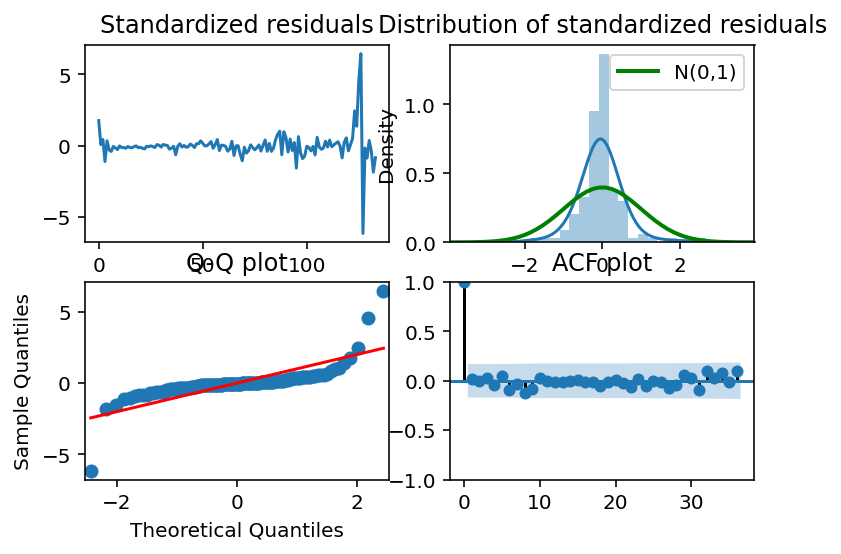

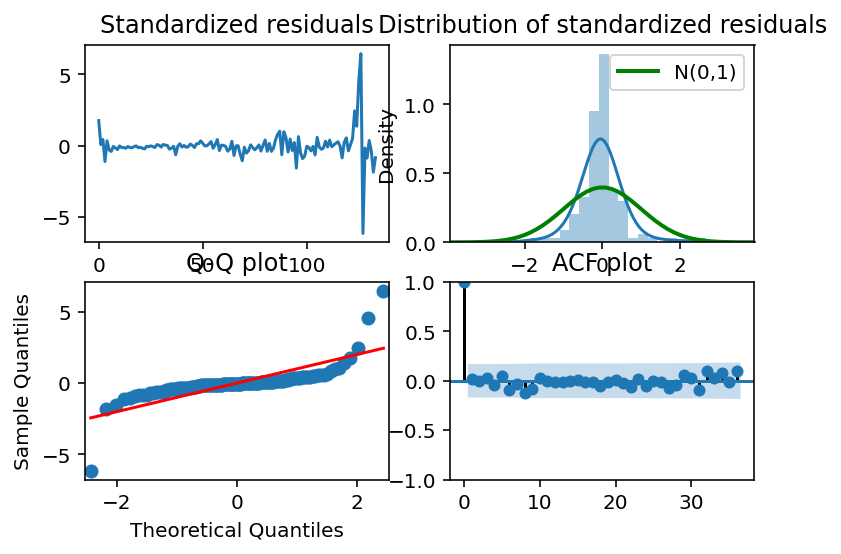

In [32]:
# Test the residuals of the fitted ARIMA model:
arima_diagnostics(arima.resid, 36)

Verify whether the model we selected based on the ACF/PACF plots is the
best one we could have selected.

In [33]:
# 1. Import the libraries:
import pmdarima as pm
# 2. Run auto_arima with the majority of the settings set to the default values (only exclude potential seasonality):
model_1 = pm.auto_arima(cronos_w['Close'],
                        error_action='ignore',
                        suppress_warnings=True,
                        seasonal=False)
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  134
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 264.508
Date:                Sun, 23 Jan 2022   AIC                           -525.016
Time:                        14:30:31   BIC                           -519.235
Sample:                             0   HQIC                          -522.667
                                - 134                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3055      0.025     12.453      0.000       0.257       0.354
sigma2         0.0011   3.92e-05     27.951      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2586.37
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              55.86   Skew:                             0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
# Tune the search of the optimal parameters:
model_2 = pm.auto_arima(cronos_w['Close'],
                        error_action='ignore',
                        suppress_warnings=True,
                        seasonal=False,
                        stepwise=False,
                        approximation=False,
                        n_jobs=-1)
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  134
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 264.821
Date:                Sun, 23 Jan 2022   AIC                           -523.643
Time:                        14:30:38   BIC                           -514.972
Sample:                             0   HQIC                          -520.119
                                - 134                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0029      0.006      0.507      0.612      -0.008       0.014
ma.L1          0.3024      0.038      8.054      0.000       0.229       0.376
sigma2         0.0011   4.04e-05     26.959      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2588.56
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):              50.86   Skew:                             0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#**Visualize Forecast model ARIMA**

In [35]:
train, test = cronos_w['Close'][cronos_w.index < '2021-11-01'], cronos_w['Close'][cronos_w.index >= '2021-11-01']
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (123,)
test shape:  (11,)


In [36]:
# from pyramid.arima import auto_arima
model_sarima = auto_arima(train, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(model_sarima.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-544.659, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-583.905, Time=0.81 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-552.525, Time=0.16 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-602.904, Time=1.66 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-617.804, Time=2.66 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.48 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=-614.012, Time=4.87 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=3.67 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-618.498, Time=2.22 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.15 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-602.998, Time=1.25 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=-615.189, Time=3.43 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-

In [37]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  123
Model:             SARIMAX(0, 1, 0)x(2, 1, [1], 12)   Log Likelihood                 313.249
Date:                              Sun, 23 Jan 2022   AIC                           -618.498
Time:                                      14:31:18   BIC                           -607.696
Sample:                                           0   HQIC                          -614.116
                                              - 123                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4022      0.119     -3.386      0.001      -0.635      -0.169
ar.S.L24      -0.2347      0.136     -1.726      0.084      -0.501       0.032
ma.S.L12      -0.8037      0.150     -5.366      0.000      -1.097      -0.510
sigma2         0.0002   1.51e-05     10.464      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):                45.29
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               5.15   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

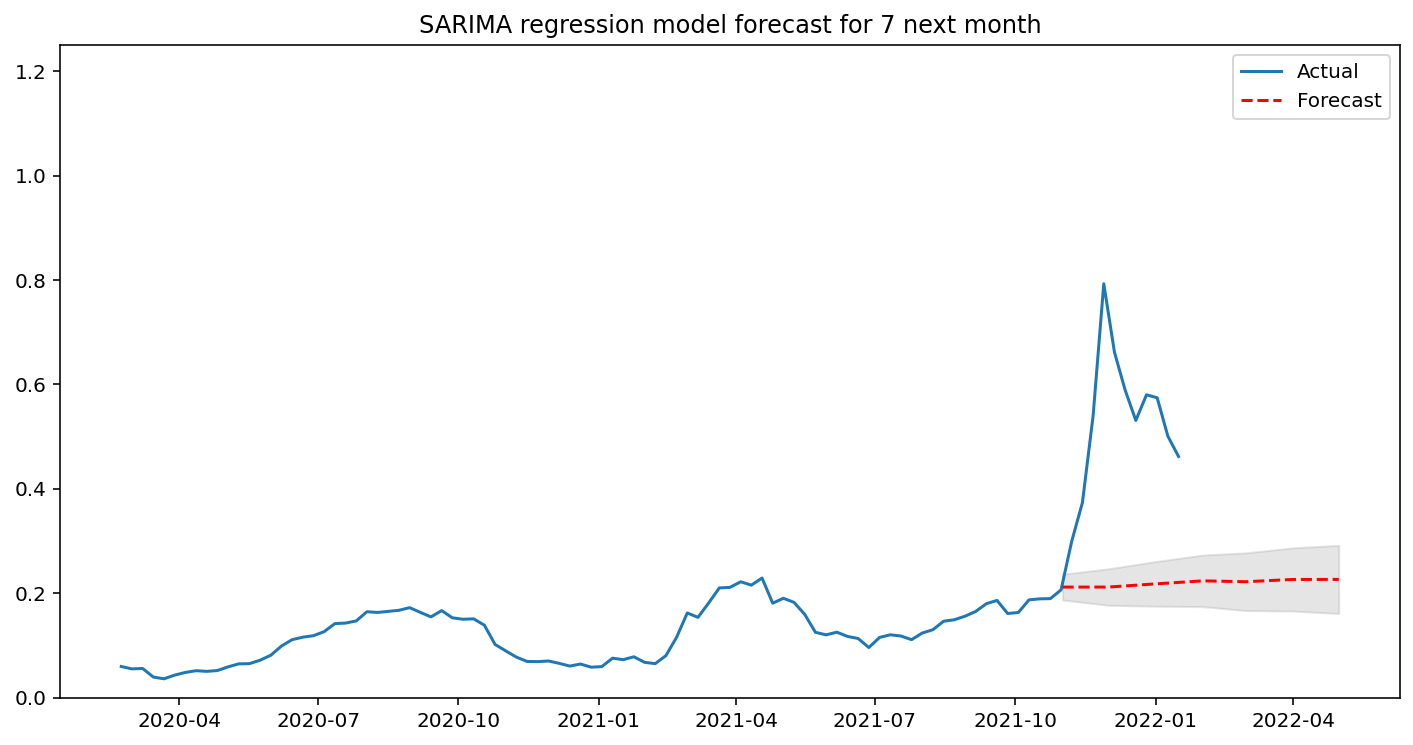

In [43]:
n_pred_perious = 7
fitted, confint = model_sarima.predict(n_periods=n_pred_perious, return_conf_int=True)
date = pd.date_range(train.index[-1], periods=n_pred_perious, freq='MS')

fitted_seri = pd.Series(fitted, index=date)
lower = confint[:, 0]
upper = confint[:, 1]

plt.figure(figsize=(12, 6))
plt.plot(cronos_w['Close'][-100:], label='Actual')
plt.plot(fitted_seri, color='red', linestyle='--', label = 'Forecast')
plt.fill_between(date, 
                 lower, 
                 upper,
                 color='grey', alpha=0.2)
plt.ylim((0, 1.25))
plt.legend()
plt.title('SARIMA regression model forecast for 7 next month')
plt.show()